# Scikit-rt appication demo

This notebook demonstrates how to define and run a scikit-rt application on datasets for multiple patients.  It uses the dataset:

Peihan Li, "SPECT_CT_data.zip", Figshare dataset (2020)<br/>
https://doi.org/10.6084/m9.figshare.12579707.v1

If not alread present on the computer where this notebook is run, the dataset will be downloaded to the directory specified by `topdir` below.

In practice, scikit-rt application code would usually run in a script, rather than in a notebook.  For a large-scale analysis, scikit-rt applications can be handled by the [ganga](https://github.com/ganga-devs/ganga) task-management system, using the [ganga-skrt](https://github.com/kh296/ganga-skrt) extension.  This allows for submission to a batch system, and for splitting tasks into multiple sub-tasks, each of which processes a subset of the patient datasets;

In [1]:
from pathlib import Path

from skrt.core import download

# Define URL of source dataset, and local data directory.
url = "https://figshare.com/ndownloader/files/23528954/SPECT_CT_data.zip"
topdir = Path("~/data/spect_ct").expanduser()
datadir = topdir / Path(url).stem

# Download dataset if not already present.
if not datadir.exists():
    download(url, topdir, unzip=True)

## Scikit-rt applications

A scikit-rt application is constructed as a sequence of algorithms, each of which inherits from the [skrt.application.Algorithm](https://scikit-rt.github.io/scikit-rt/skrt.application.html#skrt.application.Algorithm) class.  This defines three methods relating to execution:

- `initialise()` - run before any patient data are read;
- `execute()` - run once for each patient;
- `finalise()` - run after all patient data have been read.

Each method returns an instance of the [skrt.application.Status](https://scikit-rt.github.io/scikit-rt/skrt.application.html#skrt.application.Status) class,
providing information on whether execution problems were encountered.  
The `initialise()` and/or `finalise()` may be omitted from a subclass if there is
no code that needs to be executed before and/or after reading patient data.

Running of algorithm methods is handled by the [skrt.application.Application](https://scikit-rt.github.io/scikit-rt/skrt.application.html#skrt.application.Application) class.

## Example application

The code in the next cell implements an algorithm for creating and saving (CSV format) a pandas Dataframe containing summary information for patient datasets, and defines a function for
creating and configuring an application to use this algorithm.

In [2]:
'''
Application for extracting summary data.
'''

from itertools import chain
from pathlib import Path

import pandas as pd

from skrt.application import Algorithm, Application, get_paths
from skrt.core import tic, toc

class ExtractInfo(Algorithm):
    '''
    Algorithm subclass, for extracting summary data.

    Methods:
        __init__ -- Return instance of ExtractInfo class,
                    with properties set according to options dictionary.
        execute  -- Extract summary data.
    '''

    def __init__(self, opts={}, name=None, log_level=None):
        '''
        **Parameters:**

        opts: dict, default={}
            Dictionary for setting algorithm attributes.

        name: str, default=''
            Name for identifying algorithm instance.

        log_level: str/int/None, default=None
            Severity level for event logging.  If the value is None,
            log_level is set to the value of skrt.core.Defaults().log_level.
        '''
        
        # List of strings indicating types of image for which information
        # is to be retrieved, for example ['ct', 'mr'].  If None,
        # information is retrieved for all image types in the patient dataset.
        self.image_types = None
        
        # Modality of planning images.
        self.plan_image_type = "ct"

        # Name of output csv files.
        self.summary_csv = 'summary_info.csv'

        # Override default properties, based on contents of opts dictionary.
        super().__init__(opts, name, log_level)

        # List of dictionaries containing summary information for patient datasets.
        self.summary_info = []
        
        # Start timer.
        tic()

    def execute(self, patient):

        '''
        Extract summary data for patient's dataset.

        **Parameter:**

        patient: skrt.patient.Patient/None, default=None
            Object providing access to patient dataset.
        '''
        # Print details of current patient.
        print(f'\nPatient id: {patient.id}')
        patient_path = Path(patient.path)
        try:
            patient_path = f"~/{patient_path.relative_to(patient_path.home())}"
        except RuntimeError:
            pass
        print(f'Folder path: {patient_path}')

        # List of dictionaries containing summary information for patient datasets.
        self.summary_info.append(patient.get_info())
        
        # Report time taken.
        self.logger.info(f"Processing time: {toc():.2f} seconds")

        return self.status

    def finalise(self):

        df1 = pd.DataFrame(self.summary_info)
        df1.to_csv(self.summary_csv, index=False)

        return self.status


def get_app(setup_script=''):
    '''
    Define and configure application to be run.
    '''
    # Set options via a dictionary, where keywords are algorithm attributes,
    # and the associated values will be assigned to them
    # when the algorithm is instantiated.
    options = {}
    
    # Set the severity level for event logging
    log_level = 'INFO'

    # Create algorithm object
    alg = ExtractInfo(opts=options, name=None, log_level=log_level)

    # Create the list of algorithms to be run (here just the one)
    algs = [alg]

    # Create the application
    app = Application(algs=algs, log_level=log_level)

    return app

## Running application

The application's run method is passed a list of paths to patient folders,
any may optionally be passes keyword-value pairs to be used internally when creating
[skrt.patient.Patient]() objects.  Paths to patient folders may be obtained using the [skrt.application.get_paths()]() function.

In [3]:
# Define and configure the application to be run.
app = get_app()

# Algorithm options may be overwritten here.
summary_csv = "summary_info.csv"
app.algs[0].summary_csv = summary_csv

# Define the patient data to be analysed.
# Set max_path to an integer value to limit the number of patient folders considered.
paths = get_paths({datadir: ["0*"]}, max_path=None)

# Run application for the selected data
app.run(paths, unsorted_dicom=True);


Patient id: 001
Folder path: ~/data/spect_ct/SPECT_CT_data/001
ExtractInfo - INFO - Processing time: 2.66 seconds

Patient id: 002
Folder path: ~/data/spect_ct/SPECT_CT_data/002
ExtractInfo - INFO - Processing time: 2.73 seconds

Patient id: 003
Folder path: ~/data/spect_ct/SPECT_CT_data/003
ExtractInfo - INFO - Processing time: 5.31 seconds

Patient id: 004
Folder path: ~/data/spect_ct/SPECT_CT_data/004
ExtractInfo - INFO - Processing time: 5.51 seconds

Patient id: 005
Folder path: ~/data/spect_ct/SPECT_CT_data/005
ExtractInfo - INFO - Processing time: 3.07 seconds

Patient id: 006
Folder path: ~/data/spect_ct/SPECT_CT_data/006
ExtractInfo - INFO - Processing time: 3.53 seconds

Patient id: 007
Folder path: ~/data/spect_ct/SPECT_CT_data/007
ExtractInfo - INFO - Processing time: 0.89 seconds

Patient id: 008
Folder path: ~/data/spect_ct/SPECT_CT_data/008
ExtractInfo - INFO - Processing time: 3.01 seconds

Patient id: 009
Folder path: ~/data/spect_ct/SPECT_CT_data/009
ExtractInfo - IN

## Application output

The application's CSV output may be read back to a pandas Dataframe.  Some columns may be empty.  For example, anonymised data shouldn't include patient birth dates, and the dataset used for this demo doesn't include any data from patient treatment (such as guidance images for delivering radiotherapy).

In [4]:
df = pd.read_csv(summary_csv)
print(df.columns)

Index(['id', 'birth_date', 'age', 'sex', 'plan_name', 'plan_description',
       'plan_prescription_description', 'plan_fraction', 'plan_target_dose',
       'plan_targets', 'plan_organs_at_risk', 'n_study', 'image_ct_file',
       'image_ct_size', 'image_ct_obj', 'image_nm_file', 'image_nm_size',
       'image_nm_obj', 'structure_set_ct_file', 'structure_set_ct_size',
       'dose_ct_file', 'dose_ct_size', 'dose_ct_max', 'plan_ct_file',
       'plan_ct_size', 'plan_image_rois', 'plan_image_time', 'plan_image_day',
       'plan_image_year', 'plan_time', 'plan_day', 'plan_year',
       'days_plan_image_to_plan', 'whole_days_plan_image_to_plan',
       'treatment_start', 'treatment_end', 'treatment_start_day',
       'treatment_end_day', 'treatment_start_year', 'treatment_end_year',
       'days_treatment', 'whole_days_treatment', 'days_plan_to_treatment',
       'whole_days_plan_to_treatment', 'days_plan_image_to_treatment',
       'whole_days_plan_image_to_treatment', 'dose_rtdose_file

## Visualising data

Dataframe data may be visualised using pandas tools.  The following plots an example histogram, showing the numbers of individual files associated with CT images (one entry per patient in the dataset).

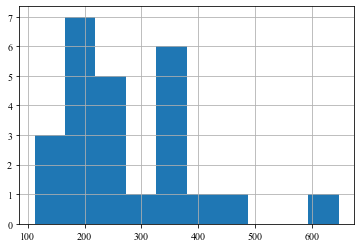

In [5]:
df["image_ct_file"].hist();